In [10]:
""" Compare the number, intensity, and length of the heat waves if a 1991-2020 window were used
    intead of 2001-2019 based on just Daymet data. 
"""
import pandas as pd
import xarray as xr
import os
import numpy as np
from utils.analysis import *
from utils.constants import *
from utils.paths import *
from utils.extremes import *
from utils.get_monthly_data import *
from utils.plotting import *
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
import seaborn as sns
from tqdm import tqdm
import cartopy.crs as ccrs
import itertools as it
from scipy.stats import mannwhitneyu


rcParams["font.size"] = 6.0
rcParams["axes.titlesize"] = 6.0

/home/ywo/conda_env/myCondaEnv/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/ywo/conda_env/myCondaEnv/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/ywo/conda_env/myCondaEnv/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


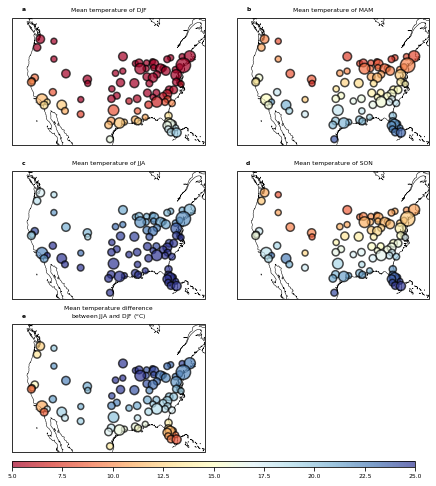

In [35]:
setup = Setup("daymet")
data = pd.read_csv(
    os.path.join(path_out, "clim", f"clim_{setup.format_prefix_noveg_noevent()}.csv"),
    index_col = [0, 1], 
    header = 0
)

lab = 'abcdefghijklmnopqrst'
fig, axes = plt.subplots(
    3,
    2,
    figsize=(8, 8),
    sharex=True,
    sharey=True,
    subplot_kw={
        "projection": ccrs.AlbersEqualArea(central_longitude=-100, central_latitude=35)
    },
)
fig.subplots_adjust(hspace=0.2, wspace=0.01)
vmin = 5
vmax = 25
for j, season in enumerate(["DJF", "MAM", "JJA", "SON"]):
    ax = axes.flat[j]
    map = MapOfColors("point", data.loc[season, 'tmean'])
    cf = map.plot(
        inset_bar=False, ax=ax, map_args=dict(vmin=vmin, vmax=vmax, cmap='RdYlBu')
    )
    ax.set_title(f'Mean temperature of {season}')
    ax.text(0.05, 1.05, lab[j], fontweight = 'bold', transform = ax.transAxes)

map = MapOfColors("point", data.loc['JJA', 'tmean'] - data.loc['DJF', 'tmean'])
cf = map.plot(
    inset_bar=False, ax=axes.flat[4], map_args=dict(vmin=vmin, vmax=vmax, cmap='RdYlBu')
)
axes.flat[4].set_title('Mean temperature difference\nbetween JJA and DJF ($^o$C)')
axes.flat[4].text(0.05, 1.05, lab[j+1], fontweight = 'bold', transform = axes.flat[4].transAxes)

axes.flat[5].axis('off')

cax = fig.add_axes([0.15, 0.1, 0.7, 0.01])
plt.colorbar(cf, cax=cax, orientation="horizontal")
fig.savefig(os.path.join(path_out, "clim", "plots", f"examine_seasonality.png"), dpi=600.0, bbox_inches="tight")
plt.close(fig)

/home/ywo/conda_env/myCondaEnv/lib/python3.8/site-packages/cartopy/crs.py:245: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(multi_line_string) > 1:
/home/ywo/conda_env/myCondaEnv/lib/python3.8/site-packages/cartopy/crs.py:297: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for line in multi_line_string:
/home/ywo/conda_env/myCondaEnv/lib/python3.8/site-packages/cartopy/crs.py:364: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  if len(p_mline) > 0:


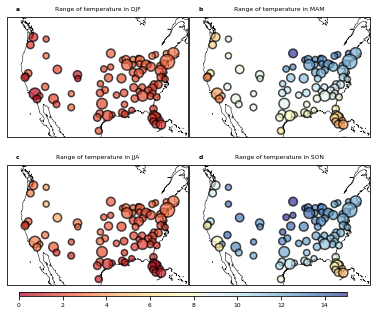

In [36]:
""" For each season, calculate the variations in climatology temperature within the season.
"""
use = 'daymet'
data = pd.DataFrame(index = range(85), columns = ['DJF', 'MAM', 'JJA', 'SON'])
for fid in range(85):
    data_ts = pd.read_csv(os.path.join(path_out, "clim", "time_series", f"{use}_{fid}.csv"), header = [0,1], index_col = 0, parse_dates = True)
    temp = data_ts.loc[:, (['tmax', 'tmin'],'all')].mean(axis = 1).groupby(data_ts.index.month).mean()
    data.loc[fid, 'DJF'] = np.max(temp.loc[[12,1,2]]) - np.min(temp.loc[[12,1,2]])
    data.loc[fid, 'MAM'] = np.max(temp.loc[[3,4,5]]) - np.min(temp.loc[[3,4,5]])
    data.loc[fid, 'JJA'] = np.max(temp.loc[[6,7,8]]) - np.min(temp.loc[[6,7,8]])
    data.loc[fid, 'SON'] = np.max(temp.loc[[9,10,11]]) - np.min(temp.loc[[9,10,11]])


lab = 'abcdefghijklmnopqrst'
fig, axes = plt.subplots(
    2,
    2,
    figsize=(6.5, 5),
    sharex=True,
    sharey=True,
    subplot_kw={
        "projection": ccrs.AlbersEqualArea(central_longitude=-100, central_latitude=35)
    },
)
fig.subplots_adjust(hspace=0.2, wspace=0.01)
vmin = 0
vmax = 15
for j, season in enumerate(["DJF", "MAM", "JJA", "SON"]):
    ax = axes.flat[j]
    map = MapOfColors("point", data.loc[:, season])
    cf = map.plot(
        inset_bar=False, ax=ax, map_args=dict(vmin=vmin, vmax=vmax, cmap='RdYlBu')
    )
    ax.set_title(f'Range of temperature in {season}')
    ax.text(0.05, 1.05, lab[j], fontweight = 'bold', transform = ax.transAxes)
cax = fig.add_axes([0.15, 0.1, 0.7, 0.01])
plt.colorbar(cf, cax=cax, orientation="horizontal")
fig.savefig(os.path.join(path_out, "clim", "plots", f"examine_seasonality2.png"), dpi=600.0, bbox_inches="tight")
#plt.close(fig)

In [33]:
data.min()

DJF    0.520757
MAM    3.303812
JJA    0.749005
SON    4.827074
dtype: object